# Understand and Apply Stereo Rectification for Stereo Matching

> See a series of blogs by [Andreas Jakl](https://www.andreasjakl.com/), a professor at St. Pölten University of Applied Sciences. 
> - Part 1: [Easily Create Depth Maps with Smartphone AR](https://www.andreasjakl.com/easily-create-depth-maps-with-smartphone-ar-part-1/)
> - Part 2: [Understand and Apply Stereo Rectification for Depth Maps](https://www.andreasjakl.com/understand-and-apply-stereo-rectification-for-depth-maps-part-2/)
> - Part 3: [How to Apply Stereo Matching to Generate Depth Maps](https://www.andreasjakl.com/how-to-apply-stereo-matching-to-generate-depth-maps-part-3/)
> - Part 4: [Compare AR Foundation Depth Maps](https://www.andreasjakl.com/compare-ar-foundation-depth-maps-part-4/)
> - Part 5: [Visualize AR Depth Maps in Unity](https://www.andreasjakl.com/visualize-ar-depth-maps-in-unity-part-5/)

> see code: https://github.com/andijakl/python-depthmaps/blob/main/disparity_map.py

## 1. Wrapping Images for Stereo Rectification

Image rectification wraps both images. The result is that they appear as if they have been taken only `with a horizontal displacement`. This simplifies calculating the disparities of each pixel!

With smartphone-based AR like in `ARCore`, the user can freely move the camera in the real world. The depth map algorithm only has the freedom to choose two distinct keyframes from the live camera stream. As such, the stereo rectification needs to be very intelligent in matching & wrapping the images!

<p align="center">
  <img src="./files/05-AR-App-Development-Google-ARCore-Depth-01-1200x675.png" alt="drawing" width="600"/>
</p>

In more technical terms, this means that after `stereo rectification`, all epipolar lines are parallel to the horizontal axis of the image.

To perform stereo rectification, we need to perform two important tasks:

- `Detect keypoints` in each image.
- We then need the best keypoints where we are sure they are `matched in both images` to calculate reprojection matrices.
- Using these, we can `rectify the images` to a common image plane. Matching keypoints are on the same horizontal epipolar line in both images. This enables efficient `pixel / block comparison` to calculate the disparity map (= how much offset the same block has between both images) for all regions of the image (not just the keypoints!).

## 2. Detecting Keypoints

Here, we’ll use the traditional `SIFT algorithm`. Its patent expired in March 2020, and the algorithm got included in the main [OpenCV implementation](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html).

### 1) Loading and Comparing Left & Right Images

In the following picture, you see both keyframes next to each other. Two horizontal blue lines are drawn at the same `y` coordinate. If you look closely, you will notice that these lines generally hit the same objects in both pictures. However, there is a slight difference: sometimes, a specific feature is higher up in one image and lower in the other.

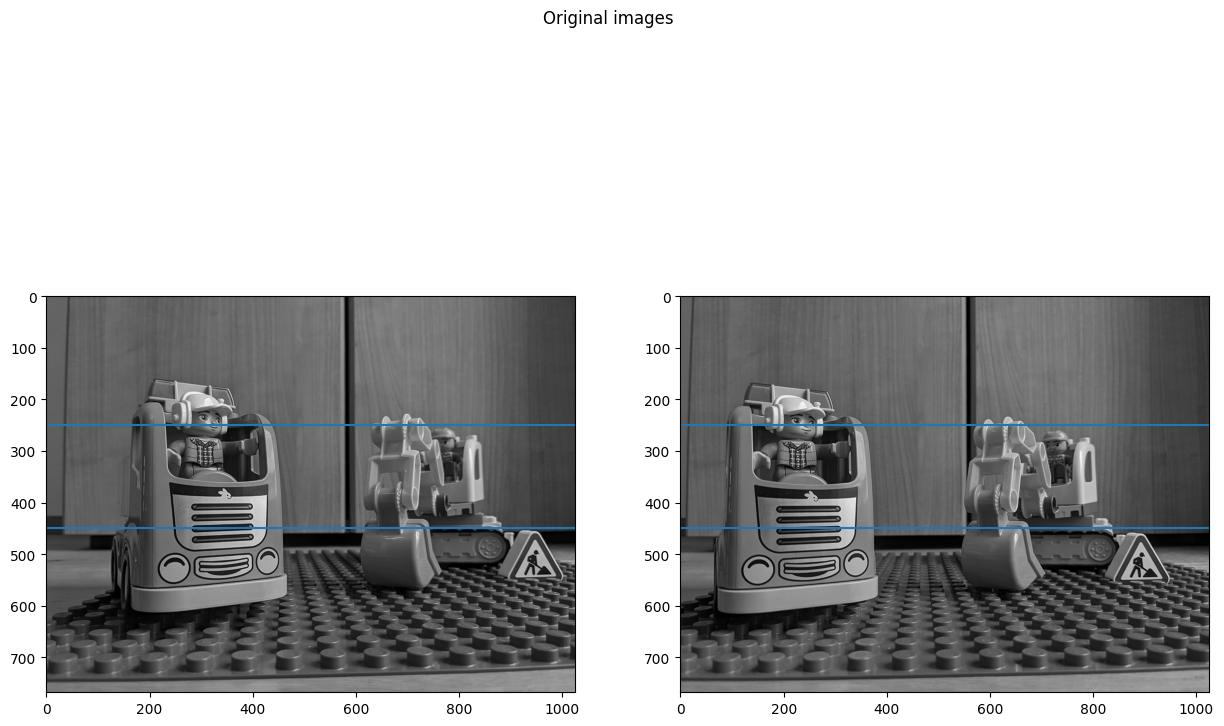

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read both images and convert to grayscale
img1 = cv2.imread('./files/left_img.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./files/right_img.png', cv2.IMREAD_GRAYSCALE)

# ------------------------------------------------------------
# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.savefig("./files/original_images.png")
plt.show()

### 2) Detecting Keypoints

In [4]:
# loading left right images


# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
print ("Found keypoints for img1")
kp2, des2 = sift.detectAndCompute(img2, None)
print ("Found keypoints for img2")

Found keypoints for img1
Found keypoints for img2


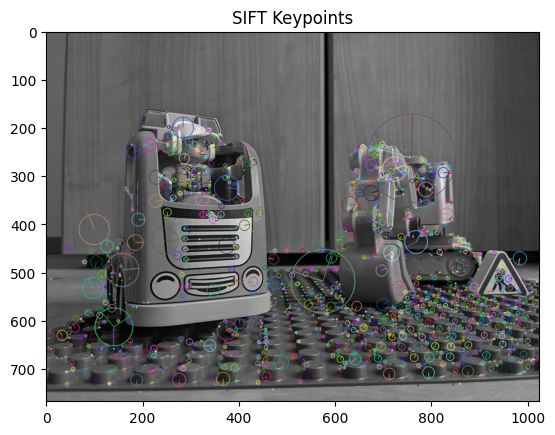

In [9]:
# Visualize keypoints
imgSift = cv2.drawKeypoints(
    img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title("SIFT Keypoints", loc='center')
plt.imshow( imgSift.astype(np.uint8))
plt.savefig("./files/sift_keypoints.png")
plt.show()
#cv2.imwrite("sift_keypoints.png", imgSift)

### 3) Matching Keypoints

The code calculated keypoints individually for each image. As these are taken from a slightly different perspective, there will also be differences in the detected points. As such, to perform stereo rectification, we next need to match the keypoints between both images. This allows to detect which are present in both images, as well as their difference in the position.

An efficient algorithm is the [FLANN matcher](https://github.com/mariusmuja/flann). It sorts the best potential matches between similar keypoints in both frames based on their distance using a K-nearest-neighbor search.

However, this usually provides far more matches than we need for the following steps. Therefore, the next few lines of code go through the keypoint matches and select the best ones, as described by Lowe (see paper “Distinctive Image Features from Scale-Invariant Keypoints,” International Journal of Computer Vision, 2004).

In [11]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

To visually check the matches, we can also draw these. As there are still a lot of matches left, I’m just selecting a few of the `matches [300:500]`. If your source images have fewer matches, remove the array selection to draw all of them!

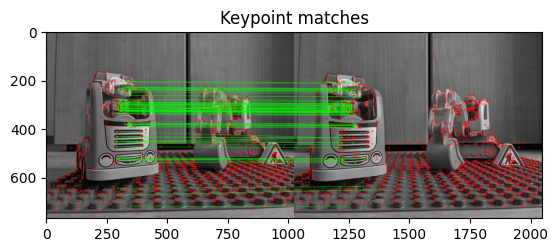

In [12]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
plt.title("Keypoint matches", loc='center')
plt.imshow( keypoint_matches.astype(np.uint8))
plt.savefig("./files/keypoint_matches.png")
plt.show()
#cv2.imshow("Keypoint matches", keypoint_matches)
#cv2.imwrite("keypoint_matches.png", keypoint_matches)

## 3. Stereo Rectification

The matching we have performed so far is a pure 2D keypoint matching. However, to put the images in a 3D relationship, we should use `epipolar geometry`. A major step to get there: the fundamental matrix describes the relationship between two images in the same scene. It can be used to map points of one image to lines in another.

What exactly is Epipolar Geometry? The [“Computer Vision” course of the Carnegie Mellon University](https://www.cs.cmu.edu/~16385/) has excellent slides that explain the principles and the mathematics. This part of their course is also using the Computer Vision: Algorithms and Applications book as source. Its second edition is currently in the works and can be read for [free online](http://szeliski.org/Book/) at the author’s website. Here, I’ll just explain the basics without the mathematical background.

### 1) Epipolar Constraint

<p align="center">
  <img src="files/epipolar_constraint-1024x576.png" alt="drawing" width="600"/>
</p>

The epipolar constraint helps with stereo rectification in that sense that potential matches for a point `x` in the first camera (`o`) lie on the epipolar plane `l’` in the second camera (`o’`).

The rectangles shown in perspective are the image planes of both cameras. The same keypoint `p` is visible at different positions `x` and `x'` in both images. However, they won’t be at the same position. Remember that in the end, we need a `disparity` between both images to estimate the depth: objects that are closer to the (horizontally) moving camera will have a greater offset when comparing two keyframes, while objects that are far away will be at roughly the same position in both images.

<p align="center">
  <img src="files/matching_points_1-1024x359.png" alt="drawing" width="600"/>
</p>

So, how do we find the match `x'` in the second image? Keep in mind that we shouldn’t just find matches for the keypoints, but for each pixel/block in the whole image to make the disparity map as dense as possible!

Luckily, when we know the reprojection matrix between both images, the epipolar constraint tells us that the matching pixel/block `x'` in the image `o'` is on the epipolar line `l'`. Otherwise, we’d have to search the whole image to find a good match.

### 2) Epipolar Lines for Stereo Rectification

These epipolar lines (epilines) will be at an angle in both images. That makes matching more computationally difficult. Stereo rectification reprojects the images to a new common plane parallel to the line between the camera centers. So, if the images are rectified, this means that calculating the disparity is a simple search along the corresponding horizontal epipolar line in the other image.

Why is the matching so simple now that we have rectified the images? We only need to use a simple block comparison algorithm. It compares a block in the left image with blocks in the right image at different disparities. The winner is the block with the minimum matching cost. The algorithm is usually a normalized cross correlation (NCC) or the sum of absolute differences (SAD). Speed matters, as we perform this operation for every block in the image to generate a full disparity map!

### 3) Fundamental Matrix

How do we rectify images in code? The `essential matrix` allows us to calculate the epipolar line in the second image given a point in the first image. The `fundamental matrix` is a more generalized version of the same concept. Given that, we can also rectify the images (= undistort), so that the images are wrapped in a way that their epilines are aligned.

OpenCV includes a function that [calculates the fundamental matrix](https://docs.opencv.org/4.5.0/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a) based on the matched keypoint pairs. It needs at least 7 pairs but works best with 8 or more. We have more than enough matches. This is where the RanSaC method (Random Sample Consensus) works well. RANSAC also considers that not all matched features are reliable. It takes a random set of point correspondences, uses these to compute the fundamental matrix and then checks how well it performs. When doing this for different random sets (usually, 8-12), the algorithm chooses its best estimate. According to OpenCV’s source code, you should have at least fifteen feature pairs to give the algorithm enough data.

The [tutorial by OpenCV about epipolar geometry](https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html) has more background info about the process. Here the adapted source code that fits to our application.

### 4) Stereo Rectification

In [14]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

- Epilines
This is enough to find epilines. You can see their visualization in the image below. The Python code marked corresponding keypoints in both images. As you can observe, they lie on the same epipolar lines.

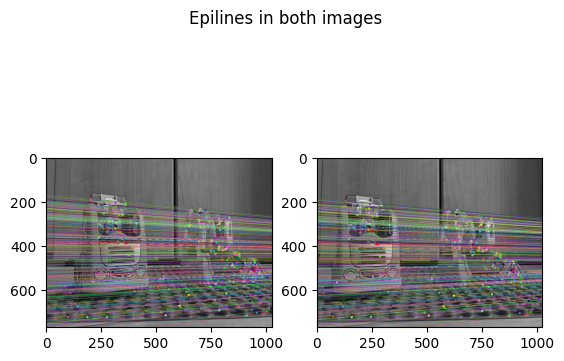

In [23]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html

def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.savefig("./files/epilines.png")
plt.show()

- How do we get the stereo rectified images? After all the preparatory steps, performing the actual stereo rectification through OpenCV is remarkably short and easy.

As we did not perform a specific camera calibration, we will use the uncalibrated version of the algorithm. Of course, this introduces further inaccuracies to an already sensitive system, given all the potential small errors that can accumulate. But in many cases, it still provides satisfactory results.

To perform the rectification, we simply pass the matched points from both images as well as the fundamental matrix into the [stereoRectifyUncalibrated()](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052) method. OpenCV’s implementation is based on Hartley et al. (R. I. Hartley, “Theory and Practice of Projective Rectification,” International Journal of Computer Vision, vol. 35, no. 2, pp. 115–127, Nov. 1999, doi: 10.1023/A:1008115206617.)

In [24]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343

h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

What we get back are the planar perspective transformations encoded by the homography matrices `H1` and `H2`. A [homography matrix](https://docs.opencv.org/master/d9/dab/tutorial_homography.html) maps a point to a point, while the essential matrix maps a point to a line.

Now let’s see if this improved the image alignment. Using OpenCV’s [warpPerspective()](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) function, we can apply the calculated transformations to the source images.

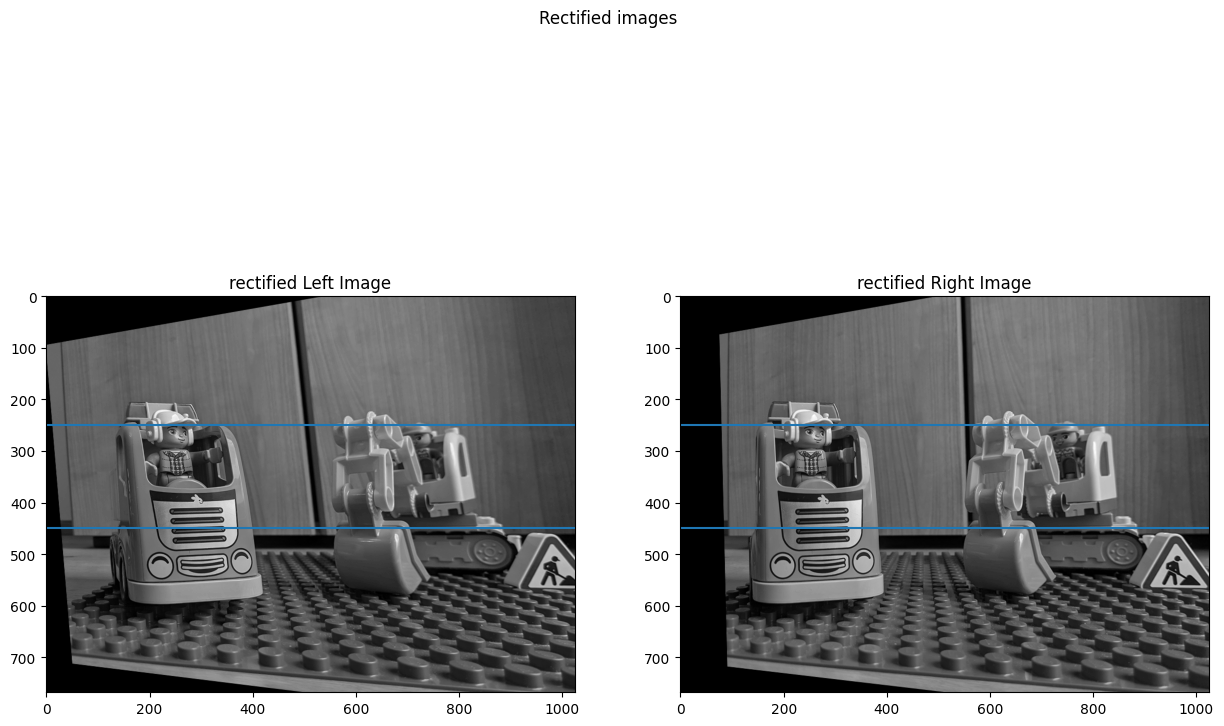

In [30]:
# Rectify (undistort) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
cv2.imwrite("./files/rectified_1.png", img1_rectified)
cv2.imwrite("./files/rectified_2.png", img2_rectified)

# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].title.set_text("rectified Left Image")
axes[1].title.set_text("rectified Right Image")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("./files/rectified_images.png")
plt.show()

As you can see, both source images have now changed. The same two blue horizontal lines are drawn on top of the images. Look closely at the distinct features in both images and compare them: they lie exactly on the same line in their respective image. A good reference point is the eye of the construction worker figure in the car.

## 4. Stereo Matching for the Disparity Map (Depth Map)

We have rectified our two camera images. Now the last major step is `stereo matching`. The algorithm that Google is using for ARCore is an optimized hybrid of two previous publications: `PatchMatch Stereo` (M. Bleyer, C. Rhemann, and C. Rother, “Patchmatch stereo - stereo matching with slanted support windows,” 2011.) and `HashMatch` (S. R. Fanello et al., “Low Compute and Fully Parallel Computer Vision with HashMatch,” in 2017 IEEE International Conference on Computer Vision (ICCV), Oct. 2017, pp. 3894–3903. doi: 10.1109/ICCV.2017.418.).

An [implementation in OpenCV](https://docs.opencv.org/master/d2/d85/classcv_1_1StereoSGBM.html) is based on `Semi-Global Matching (SGM)` as published by Hirschmüller (H. Hirschmuller, “Stereo Processing by Semiglobal Matching and Mutual Information,” IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 30, no. 2, pp. 328–341, Feb. 2008, doi: 10.1109/TPAMI.2007.1166.). In Google’s paper (J. Valentin et al., “Depth from motion for smartphone AR,” ACM Trans. Graph., vol. 37, no. 6, p. 193:1-193:19, Dec. 2018, doi: 10.1145/3272127.3275041.), they compare themselves to an implementation of Hirschmüller and outperform those; but for the first experiments, OpenCV’s default is good enough and provides plenty of room for experimentation.

OpenCV documentation includes an example for stereo maching and disparity or depth map generation. See a python example by OpenCV at [stereo_match.py](https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py).

Most of the following code in this article is just an explanation of the configuration options based on the documentation. Setting fitting values for the scenes you expect is crucial to the success of this algorithm. Some insights are listed in the [Choosing Good Stereo Parameters](http://wiki.ros.org/stereo_image_proc/Tutorials/ChoosingGoodStereoParameters) article. These are the most important settings to consider:

- **Block size**: if set to 1, the algorithm matches on the pixel level. Especially for higher resolution images, bigger block sizes often lead to a cleaner result.
- **Minimum / maximum disparity**: this should match the expected movements of objects within the images. In freely moving camera settings, a negative disparity could occur as well – when the camera doesn’t only move but also rotate, some parts of the image might move from left to right between keyframes, while other parts move from right to left.
- **Speckle**: the algorithm already includes some smoothing by avoiding small speckles of different depths than their surroundings.

computing disparity...


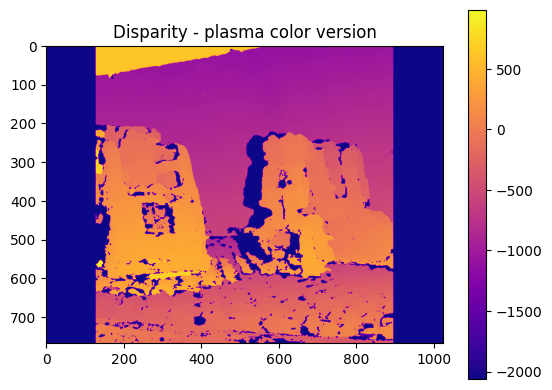

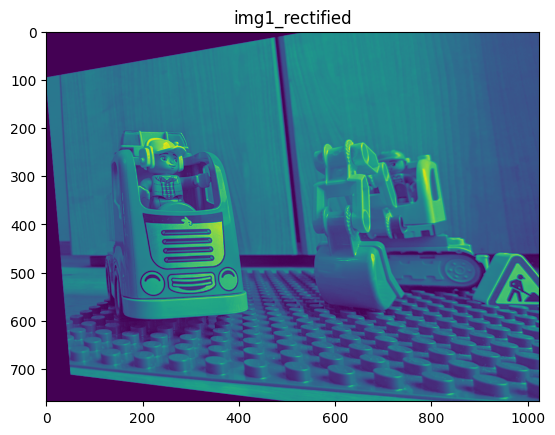

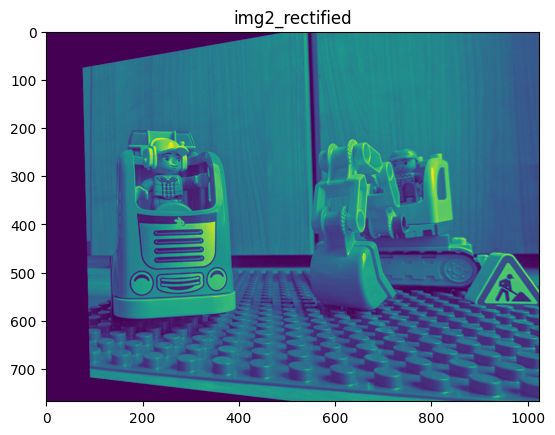

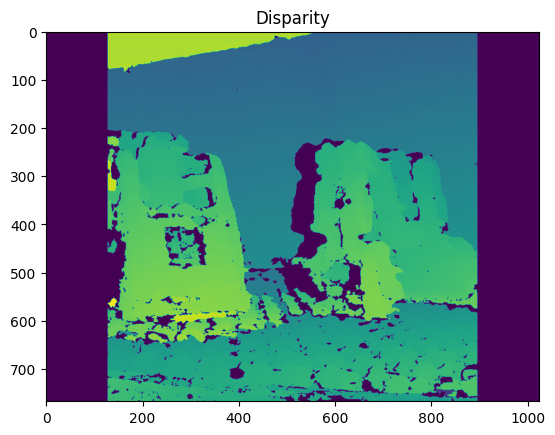

In [31]:
# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)
# Adapted from: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

# StereoSGBM Parameter explanations:
# https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp

# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5

# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200

# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = block_size,
    uniquenessRatio = uniquenessRatio,
    speckleWindowSize = speckleWindowSize,
    speckleRange = speckleRange,
    disp12MaxDiff = disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

print('computing disparity...')
disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

plt.imshow(disparity_SGBM, cmap='plasma')
plt.title("Disparity - plasma color version", loc='center')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv2.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv2.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

#cv2.imshow("Disparity", disparity_SGBM)
#cv2.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

plt.title("img1_rectified", loc='center')
plt.imshow(img1_rectified)
plt.show()

plt.title("img2_rectified", loc='center')
plt.imshow(img2_rectified)
plt.show()

plt.title("Disparity", loc='center')
plt.imshow(disparity_SGBM)
plt.savefig("./files/disparity_SGBM_norm.png")
plt.show()

## 5. Filtering & Point Cloud

- The depth map we generated is sparse. This means that it only contains information in textured regions; you can clearly see that it struggled calculating the depth in the excavator’s shovel.

- This is a good example of a region `with insufficient texture`. Another issue are regions that are only visible in one of the images but occluded in the other. As such, to generate a full depth map, you should also apply filtering to fill these gaps. An example can be found in the [OpenCV Disparity map post-filtering article](https://docs.opencv.org/4.x/d3/d14/tutorial_ximgproc_disparity_filtering.html).

- Additionally, our depth map process would be temporally inconsistent and is not aligned to edges of the image. Google optimized the depth maps in ARCore using bilateral solver extensions [4]. However, we won’t go into details here.

- Another task would be creating a point cloud based on the disparity map. OpenCV [stereo_match.py sample](https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py) shows some sample code for this.

- Also note that our disparity map doesn’t directly reveal the distance in meters, so you’d have to convert the values of the disparity map to depth. Depending on the exact system setup (polar rectification vs. other methods), this can be trivial or a more complex triangulation.